# LiDAR analysis

## Introduction

This notebook shows how to find, read, subset and inspect **lvis level-2a** (l2a) granules over field sites.

#### Note:

The notebook was done on the [BioSCape's Cloud Environment](https://cloud.bioscape.io/) which provides direct access to data and computational resources. Access to the cloud environment can be requested at bioscape.io/data.

### Import python modules

In [4]:
# Import python modules
from glob import glob
import numpy as np
import pandas as pd
import earthaccess
import geopandas as gpd
import requests as re
import folium
import s3fs
import h5py
from os import path
from pathlib import Path
from datetime import datetime
from shapely.geometry import Polygon, MultiPolygon, box
import matplotlib.pyplot as plt
import linecache
import contextily as cx
import dask.dataframe as dd
from shapely.ops import orient, unary_union
from shapely.validation import make_valid
from harmony import BBox,Client, Collection, Request, LinkType

### Define the esri tiles url and attribution used for folium maps

In [30]:
# Esri background basemap for maps
Esri_xyz = "https://server.arcgisonline.com/ArcGIS/rest/services/World_Imagery/MapServer/tile/{z}/{y}/{x}"
Esri_attribution = "ESRI"

In [31]:
# List the LVIS folders at the BioSCape SMCE
S3_filesystem = s3fs.S3FileSystem(anon=False)
Lvis_folders = s3.ls('bioscape-data/LVIS')
lvis_folders

['bioscape-data/LVIS/L1B', 'bioscape-data/LVIS/L2']

### Read the site polygons and show them on a small folium map

We read the geojson files that define each field plot/site, unify them into a single geopandas geodataframe (`All_sites_gdf`) and compute a center for initial folium map view.

Notes for readers with no GIS background:
- A geojson contains polygon geometries; geopandas reads them and understands coordinate reference systems (crs)
- Folium shows the polygons on a slippy map in the notebook / in html

In [32]:
# Read all sites and tag them ---
Sites_files = {
    "Site1": "data/field_plots/Site1.geojson",
    "Site2": "data/field_plots/Site2.geojson",
    "Site3": "data/field_plots/Site3.geojson",
    "Site4": "data/field_plots/Site4.geojson",
    "Site5": "data/field_plots/Site5.geojson",
    "Site6": "data/field_plots/Site6.geojson",
    "Site7": "data/field_plots/Site7.geojson",
}

Site_gdfs = []
for site_name, site_path in Sites_files.items():
    gdf = gpd.read_file(site_path)
    gdf["site"] = site_name
    # If CRS is missing or not geographic, bring everything to EPSG:4326 for Folium
    if gdf.crs is None:
        # If you know the source CRS, set it here before converting.
        # gdf = gdf.set_crs("EPSG:XXXX")
        pass
    Site_gdfs.append(gdf)

All_sites_gdf = pd.concat(Site_gdfs, ignore_index=True)
All_sites_gdf = All_sites_gdf.to_crs("EPSG:4326")  # safe even if already 4326

All_sites_centroid = All_sites_gdf.unary_union.centroid
Folium_map = folium.Map(location=[All_sites_centroid.y, All_sites_centroid.x], zoom_start=12, control_scale=True, tiles=None)

try:
    folium.TileLayer(tiles=Esri_xyz, attr=Esri_attribution, name="Custom").add_to(Folium_map)
except NameError:
    folium.TileLayer("OpenStreetMap", name="OSM").add_to(Folium_map)
    folium.TileLayer(
        tiles="https://server.arcgisonline.com/ArcGIS/rest/services/World_Imagery/MapServer/tile/{z}/{y}/{x}",
        attr="Esri, Maxar, Earthstar Geographics",
        name="ESRI World Imagery"
    ).add_to(Folium_map)

All_sites_gdf.explore(m=Folium_map,
    column="site",
    legend=True,
    name="All Sites",
    tooltip=["site"],
    style_kwds={"fill": False, "weight": 2}
)

Skipping field center: unsupported OGR type: 3
/tmp/ipykernel_440/4276048821.py:26: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  centroid = all_sites.unary_union.centroid


### Build a single query polygon and search for LVIS L2A granules

What this code does is dissolve the site polygons into a single polygon and simplify it for the earthaccess query. It then queries the LVIS l2a collection (by doi) for a given date range and polygon

notes:
- Earthaccess allows convenient programmatic queries against NSIDC's CMR. you may need to login (ea.login()).
- The polygon is simplified so the query URL does not exceed web limits

In [6]:
# Build a single, simple polygon for querying
region_of_interest = unary_union(All_sites_gdf.geometry)                         # Dissolve to one geometry
region_of_interest = region_of_interest.convex_hull                              # Single polygon is easiest for search
region_of_interest = orient(region_of_interest, sign=1.0)                        # Counter-clockwise (tidy)
region_of_interest = region_of_interest.simplify(0.005, preserve_topology=True)  # Reduce vertices for url limits

# Extract a closed lon/lat ring for the API polygon parameter
roi_xs, roi_ys = region_of_interest.exterior.xy  # Shapely returns a closed ring already
roi_coords = list(zip(roi_xs, roi_ys))
if roi_coords[0] != roi_coords[-1]:              # Ensures closure
    roi_coords.append(roi_coords[0])

# Query LVIS L2A (by DOI) over polygon and temporal window
import earthaccess as earthaccess_client
# earthaccess_client.login()  # if needed

Lvis_search_results = earthaccess_client.search_data(
    doi="10.5067/VP7J20HJQISD",
    temporal=("2023-10-01", "2023-11-30"),
    polygon=roi_coords,
    count=-1
)
print(f"Granules found: {len(Lvis_search_results)}")

Granules found: 16
Granules found: 16


### Convert the earthaccess results to a geopandas dataframe and view footprints

We convert the UMM geometry returned by earthaccess into shapely polygons then produce a geopandas dataframe with a `geometry` column so we can visualise footprints.

In [33]:
def convert_umm_geometry_to_multipolygon(gpoly)::
    """converts an earthaccess UMM geometry structure into shapely multipolygon"""
    multipolygons = []
    for gl in gpoly:
        latlon_list = gl["Boundary"]["Points"]
        points = [(p["Longitude"], p["Latitude"]) for p in ltln]
        multipolygons.append(Polygon(points))
    return MultiPolygon(multipolygons)

def convert_umm_list_to_gdf(datag):
    """converts a list of earthaccess granule objects to a geopandas GeoDataFrame"""
    # Create pandas dataframe from json
    df = pd.json_normalize([vars(granule)['render_dict'] for granule in datag])
    # Keep only last string of the column names
    df.columns=df.columns.str.split('.').str[-1]
    # Convert GPolygons to shapely multi-polygons
    df["geometry"] = df["GPolygons"].apply(convert_umm_geometry_to_multipolygon)
    # Return a geopandas dataframe
    return gpd.GeoDataFrame(df, geometry="geometry", crs="EPSG:4326")

Lvis_granules_gdf = convert_umm_list_to_gdf(Lvis_search_results)
map_for_granules = Lvis_granules_gdf[['BeginningDateTime','geometry']].explore(tiles=Esri_xyz, attr=Esri_attribution, 
                                              style_kwds={'fillOpacity':0.1})
map_for_granules

The footprints plotted here are the areas covered by each LVIS granule. We use them to decide which granules overlap our sites and which files to read. 


Next we inspect data links for a particular granule. This returns remote urls:

**_The data_links for a granule show the files (.txt) that can be downloaded or accessed on S3._**

In [34]:
Lvis_search_results[1].data_links()

['https://data.nsidc.earthdatacloud.nasa.gov/nsidc-cumulus-prod-protected/LVIS/LVISF2/1/2023/10/28/LVISF2_BioSCape2023_1028_R2404_051113.TXT']

### Build a list of bioscape s3 file paths for the overlapping granules

For each granule that overlaps our site polygon, we find the matching file in the bioscape s3 bucket (this repository stores lvis l2 text files).

In [37]:
# Replace the overlapping granule names with those in the BioSCape S3 bucket.
Lvis_s3_filepaths = []
for s in Lvis_granules_gdf.index:
    Lvis_s3_filepaths.append(path.join('s3://bioscape-data/LVIS/L2/', 
                            path.basename(Lvis_search_results[s].data_links()[0])))
Lvis_s3_filepaths

['s3://bioscape-data/LVIS/L2/LVISF2_BioSCape2023_1028_R2404_050431.TXT',
 's3://bioscape-data/LVIS/L2/LVISF2_BioSCape2023_1028_R2404_051113.TXT',
 's3://bioscape-data/LVIS/L2/LVISF2_BioSCape2023_1028_R2404_051210.TXT',
 's3://bioscape-data/LVIS/L2/LVISF2_BioSCape2023_1028_R2404_052128.TXT',
 's3://bioscape-data/LVIS/L2/LVISF2_BioSCape2023_1029_R2404_036051.TXT',
 's3://bioscape-data/LVIS/L2/LVISF2_BioSCape2023_1029_R2404_037033.TXT',
 's3://bioscape-data/LVIS/L2/LVISF2_BioSCape2023_1029_R2404_037808.TXT',
 's3://bioscape-data/LVIS/L2/LVISF2_BioSCape2023_1029_R2404_038739.TXT',
 's3://bioscape-data/LVIS/L2/LVISF2_BioSCape2023_1029_R2404_039532.TXT',
 's3://bioscape-data/LVIS/L2/LVISF2_BioSCape2023_1029_R2404_039619.TXT',
 's3://bioscape-data/LVIS/L2/LVISF2_BioSCape2023_1029_R2404_040572.TXT',
 's3://bioscape-data/LVIS/L2/LVISF2_BioSCape2023_1029_R2404_041386.TXT',
 's3://bioscape-data/LVIS/L2/LVISF2_BioSCape2023_1029_R2404_044604.TXT',
 's3://bioscape-data/LVIS/L2/LVISF2_BioSCape2023_11

### Helper to detect header rows and read LVIS text file from s3

LVIS l2 text files have a header block starting with '#' lines that list column names. The helper finds how many header lines to skip and returns the column names.

In [38]:
# Parse helper
def get_header_line_count(filename):
    """Determine the number of header lines in an LVIS L2A text file"""
    count = 0
    with S3_filesystem.open(filename, 'rb') as f:
        for line in f:
            if line.startswith(b'#'):
                count = count + 1
                columns = line[1:].split()
            else:
                return count, columns

We then create a 100 m buffer around each field site then read the text file into a pandas dataframe, create a geometry column, and spatially subset to our site buffer.

In [39]:
# create a buffer around field sites
sites_buffer_utm = All_sites_gdf.to_crs("EPSG:22234") # UTM 34 S
sites_buffer_utm.geometry = sites_buffer_utm.geometry.buffer(100) # 100m buffer to capture nearby returns
sites_buffer_wgs84_gdf = sites_buffer_utm.to_crs("EPSG:4326")

# Read the LVIS L2A files and subset to points within the buffered sites
Lvis_l2a_list = []
for filepath in Lvis_s3_filepaths:
    header_count, column_names = get_header_line_count(filepath)
    temp_dataframe = pd.read_csv(filepath, skiprows=header_count, header=None, 
                          engine='python', sep=r'\s+')
    temp_dataframe.columns =  [x.decode() for x in column_names]
    temp_gdf = gpd.GeoDataFrame(temp_dataframe, 
                                geometry=gpd.points_from_xy(temp_dataframe.GLON, 
                                                            temp_dataframe.GLAT),
                                crs="EPSG:4326")
    temp_subset = gpd.sjoin(temp_gdf, sites_buffer_wgs84_gdf, predicate='within')
    if not temp_subset.empty:
        print(f'Subsetting {path.basename(filepath)}')
        Lvis_l2a_list.append(temp_subset)
Lvis_l2a_combined_gdf = pd.concat(Lvis_l2a_list)

Subsetting LVISF2_BioSCape2023_1028_R2404_051113.TXT
Subsetting LVISF2_BioSCape2023_1028_R2404_052128.TXT
Subsetting LVISF2_BioSCape2023_1029_R2404_037033.TXT
Subsetting LVISF2_BioSCape2023_1029_R2404_037808.TXT
Subsetting LVISF2_BioSCape2023_1029_R2404_040572.TXT
Subsetting LVISF2_BioSCape2023_1029_R2404_041386.TXT
Subsetting LVISF2_BioSCape2023_1113_R2404_034819.TXT
Subsetting LVISF2_BioSCape2023_1113_R2404_039379.TXT


`Lvis_l2a_combined_gdf` now contains all LVIS returns (points) that fall within the 100 m buffered sites. These points include columns such as RH100 (relative height at 100%), GLON/GLAT (longitude/latitude), and other LVIS-derived metrics."

### Height of top canopy

The code cell below builds a clipped set of LiDAR shots (points) and approximate LiDAR footprints (buffers) restricted to our site polygons. We compute percentiles of the relative height metric (RH100) and render an interactive folium map showing clipped shots coloured by RH100.

In [40]:
Footprint_Diameter_m = 25.0
Footprint_Radius_m = Footprint_Diameter_m / 2.0
UTM_EPSG = 32734  # UTM 34S (metres)

# ----------
# Bring site polygons into a metric CRS so buffering is in metres
Sites_Utm = All_sites_gdf[["site", "geometry"]].to_crs(UTM_EPSG).copy()
# Fix minor invalid geometries by buffering zero (keeps topology)
Sites_Utm["geometry"] = Sites_Utm.buffer(0

# Dissolve to one geometry per site (so each site has a single polygon)
Sites_Dissolved = Sites_Utm.dissolve(by="site")
# A union mask used to trim footprints so circles do not spill outside site polygons
Mask_Union = gpd.GeoDataFrame(geometry=[Sites_Dissolved.unary_union], crs=Sites_Dissolved.crs)

# ----------
# Drop missing RH100 values and project points to metres
Shots_Utm = Lvis_l2a_combined_gdf[["RH100", "geometry"]].dropna(subset=["RH100"]).to_crs(UTM_EPSG)

# Spatial join keeps points that intersect site polygons; index_right becomes site index
Shots_Clipped_Utm = gpd.sjoin(Shots_Utm, Sites_Dissolved, how="inner", predicate="intersects")
Shots_Clipped_Utm = Shots_Clipped_Utm.rename(columns={"index_right": "site"})[["site", "RH100", "geometry"]]

# -----------
# create circular footprints (buffers) around each clipped shot in metres
Footprints_Utm = Shots_Clipped_Utm[["site", "geometry"]].copy()
Footprints_Utm["geometry"] = Footprints_Utm.buffer(Footprint_Radius_m)      # circles in metres

# trim the circular footprints to the site polygons so they don't extend outside
Footprints_Clipped_Utm = gpd.clip(Footprints_Utm, Mask_Union)

# -----------
# Hop back to WGS84 for Folium rendering
Shots_Web = Shots_Clipped_Utm.to_crs(4326)
Footprints_Web = Footprints_Clipped_Utm.to_crs(4326)
Sites_Web = Sites_Utm.to_crs(4326)

# -----------
# Robust colorstretch: 2nd and 98th percentiles to avoid outlier stretch
vmin, vmax = np.nanpercentile(Shots_Web["RH100"], [2, 98])

map_display = Shots_Web.explore(
    column="RH100",
    cmap="YlGn",
    vmin=float(vmin), vmax=float(vmax),
    tiles=Esri_xyz, attr=Esri_attribution,
    alpha=0.6, radius=6,
    legend=True,
    legend_kwds={"position": "bottomright", "caption": "LVIS RH100 (m)"},
    tooltip=["site", "RH100"],
    name="RH100 shots (clipped)"
)

# Add site polygons with a categorical legend
Sites_Web.explore(
    m=map_display,
    name="Sites (polygons)",
    column="site",
    categorical=True,
    legend=True,
    legend_kwds={"position": "topleft", "caption": "Sites"},
    tooltip=["site"],
    style_kwds={"fill": False, "weight": 2}
)

# Optional: clipped footprints layer (toggleable)
Footprints_Web.explore(
    m=map_display,
    name=f"LVIS footprints (clipped, ~{int(Footprint_Diameter_m)} m)",
    style_kwds={"fill": False, "color": "red", "weight": 1, "opacity": 0.7},
    tooltip=["site"]
)

folium.LayerControl(position="bottomleft", collapsed=True).add_to(map_display)
map_display  # display the interactive map

/tmp/ipykernel_440/2664574201.py:15: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  mask_union = gpd.GeoDataFrame(geometry=[sites_diss.unary_union], crs=sites_diss.crs)


In [ ]:
# Save clean layers for QGIS

ut_Geopackage = "data/outputs/lvis_sites_clipped.gpkg"
Sites_Web[["site", "geometry"]].to_file(Out_Geopackage, layer="sites", driver="GPKG")
Shots_Web[["site", "RH100", "geometry"]].to_file(Out_Geopackage, layer="lvis_shots_clipped", driver="GPKG")
Footprints_Web[["site", "geometry"]].to_file(Out_Geopackage, layer="lvis_footprints_clipped", driver="GPKG")

# save the interactive folium map as html
Html_Output = "data/outputs/lvis_rh100_sites_clipped.html"
map_display.save(Html_Output)

print("Wrote:",
      "\n •", Html_Output,
      f"\n • {Out_Geopackage}  [layers: sites, lvis_shots_clipped, lvis_footprints_clipped]")

## Relative Height Distribution

The relative height distribution plot of the RH metrics is created to to check if the vegetation height across the percentile of waveform energy indicates the same.

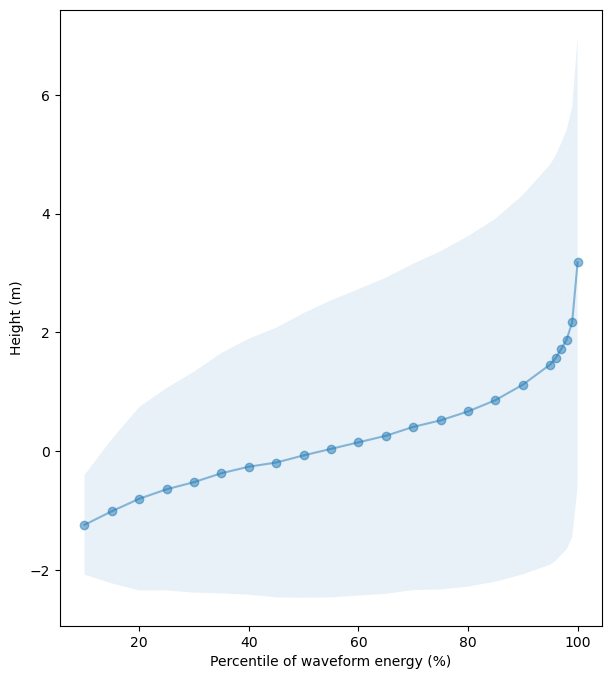

In [14]:
fig, ax = plt.subplots(figsize=(7, 8))

# Sample the LVIS level-2a geodataframe and pick RH columns
plot_df = Lvis_l2a_geodataframe.sample(frac=0.1, random_state=1).filter(like='RH').drop('CHANNEL_RH', axis=1).T
plot_df.index = plot_df.index.str.strip('RH').astype(int)
std_df = plot_df.std(axis=1)
median_df = plot_df.median(axis=1)

median_df.plot(ax=ax, alpha=0.5, style='o-')
ax.fill_between(plot_df.index, median_df - std_df, median_df + std_df, alpha=0.1)
ax.set_xlabel("Percentile of waveform energy (%)")
ax.set_ylabel("Height (m)")
plt.show()

In [29]:
# Exporting 
Lvis_l2a_geodataframe.geometry.to_file('data/outputs/lvis2_rh_distribution.geojson', driver="GeoJSON")
Lvis_l2a_geodataframe.to_csv('data/outputs/lvis_rh_distribution.csv')

### DIAGNOSTIC: guarantee clipping and print per-site RH100 summaries

In [41]:
# Pick your authoritative clipped points
Gdf_points_clipped = None
if 'Pts_web_gdf' in globals():
    Gdf_points_clipped = Pts_web_gdf.copy()
else:
    # Fall back: clip raw Lvis_l2a_geodataframe against Sites_polygons_web_gdf polygons
    assert 'Lvis_l2a_geodataframe' in globals(), "Need Lvis_l2a_geodataframe"
    assert 'Sites_polygons_web_gdf' in globals() or 'Buffer_polygons_web_gdf' in globals(), "Need Sites_polygons_web_gdf or Buffer_polygons_web_gdf polygons"
    Base_gdf = Lvis_l2a_geodataframe.copy()
    Polygons_reference_gdf = Sites_polygons_web_gdf if 'Sites_polygons_web_gdf' in globals() else Buffer_polygons_web_gdf

    # Align CRS
    if Base_gdf.crs is None:
        raise ValueError("Lvis_l2a_geodataframe has no CRS; set it correctly before clipping.")
    if Polygons_reference_gdf.crs != Base_gdf.crs:
        Polygons_reference_gdf = Polygons_reference_gdf.to_crs(Base_gdf.crs)

    # Keep points that fall within site polygons/buffers
    Gdf_points_clipped = gpd.sjoin(Base_gdf, Polygons_reference_gdf[['site','geometry']], predicate="within", how="inner")
    # sjoin may create 'index_right'; keep one 'site' column
    if 'site_right' in Gdf_points_clipped.columns and 'site' in Gdf_points_clipped.columns:
        Gdf_points_clipped['site'] = Gdf_points_clipped['site_right']
        Gdf_points_clipped = Gdf_points_clipped.drop(columns=['site_right'])

# Clean site labels to 1..7
def Clean_site(raw_value):
    s = str(raw_value).strip()
    for token in ("Site", "site"):
        if s.startswith(token):
            s = s[len(token):].strip()
    try:
        return int(s)
    except Exception:
        return s

Gdf_points_clipped = Gdf_points_clipped.copy()
Gdf_points_clipped['site_clean'] = Gdf_points_clipped['site'].apply(Clean_site)

# Basic checks
needed_columns = ['RH100']
if not all(c in Gdf_points_clipped.columns for c in needed_columns):
    raise ValueError(f"Missing columns in points: {needed_columns}")

summary = (Gdf_points_clipped
           .groupby('site_clean')['RH100']
           .agg(n='count', min='min', q50='median', q75=lambda s: s.quantile(0.75), max='max')
           .sort_index())
print(summary)

# (Optional) spot outliers by site: very tall values compared to the upper quartile
summary['suspect_outlier'] = (summary['max'] > summary['q75'] * 1.8)
print("\nPotential outliers (max >> Q3):\n", summary.loc[summary['suspect_outlier']])

             n   min    q50     q75    max
site_clean                                
1           10  1.79  2.580  2.8800   5.77
2           10  1.87  2.200  3.2200   3.41
3            6  3.07  3.460  3.8225   4.00
4            5  1.42  1.900  4.8100   4.97
5            8  2.13  2.880  3.4400   4.42
6            4  3.74  4.455  4.4900   4.49
7            4  3.60  8.635  9.4400  10.34

Potential outliers (max >> Q3):
              n   min   q50   q75   max  suspect_outlier
site_clean                                             
1           10  1.79  2.58  2.88  5.77             True


### RH profiles by site — robust site labelling, fixed x-ticks, anti-overlap labels

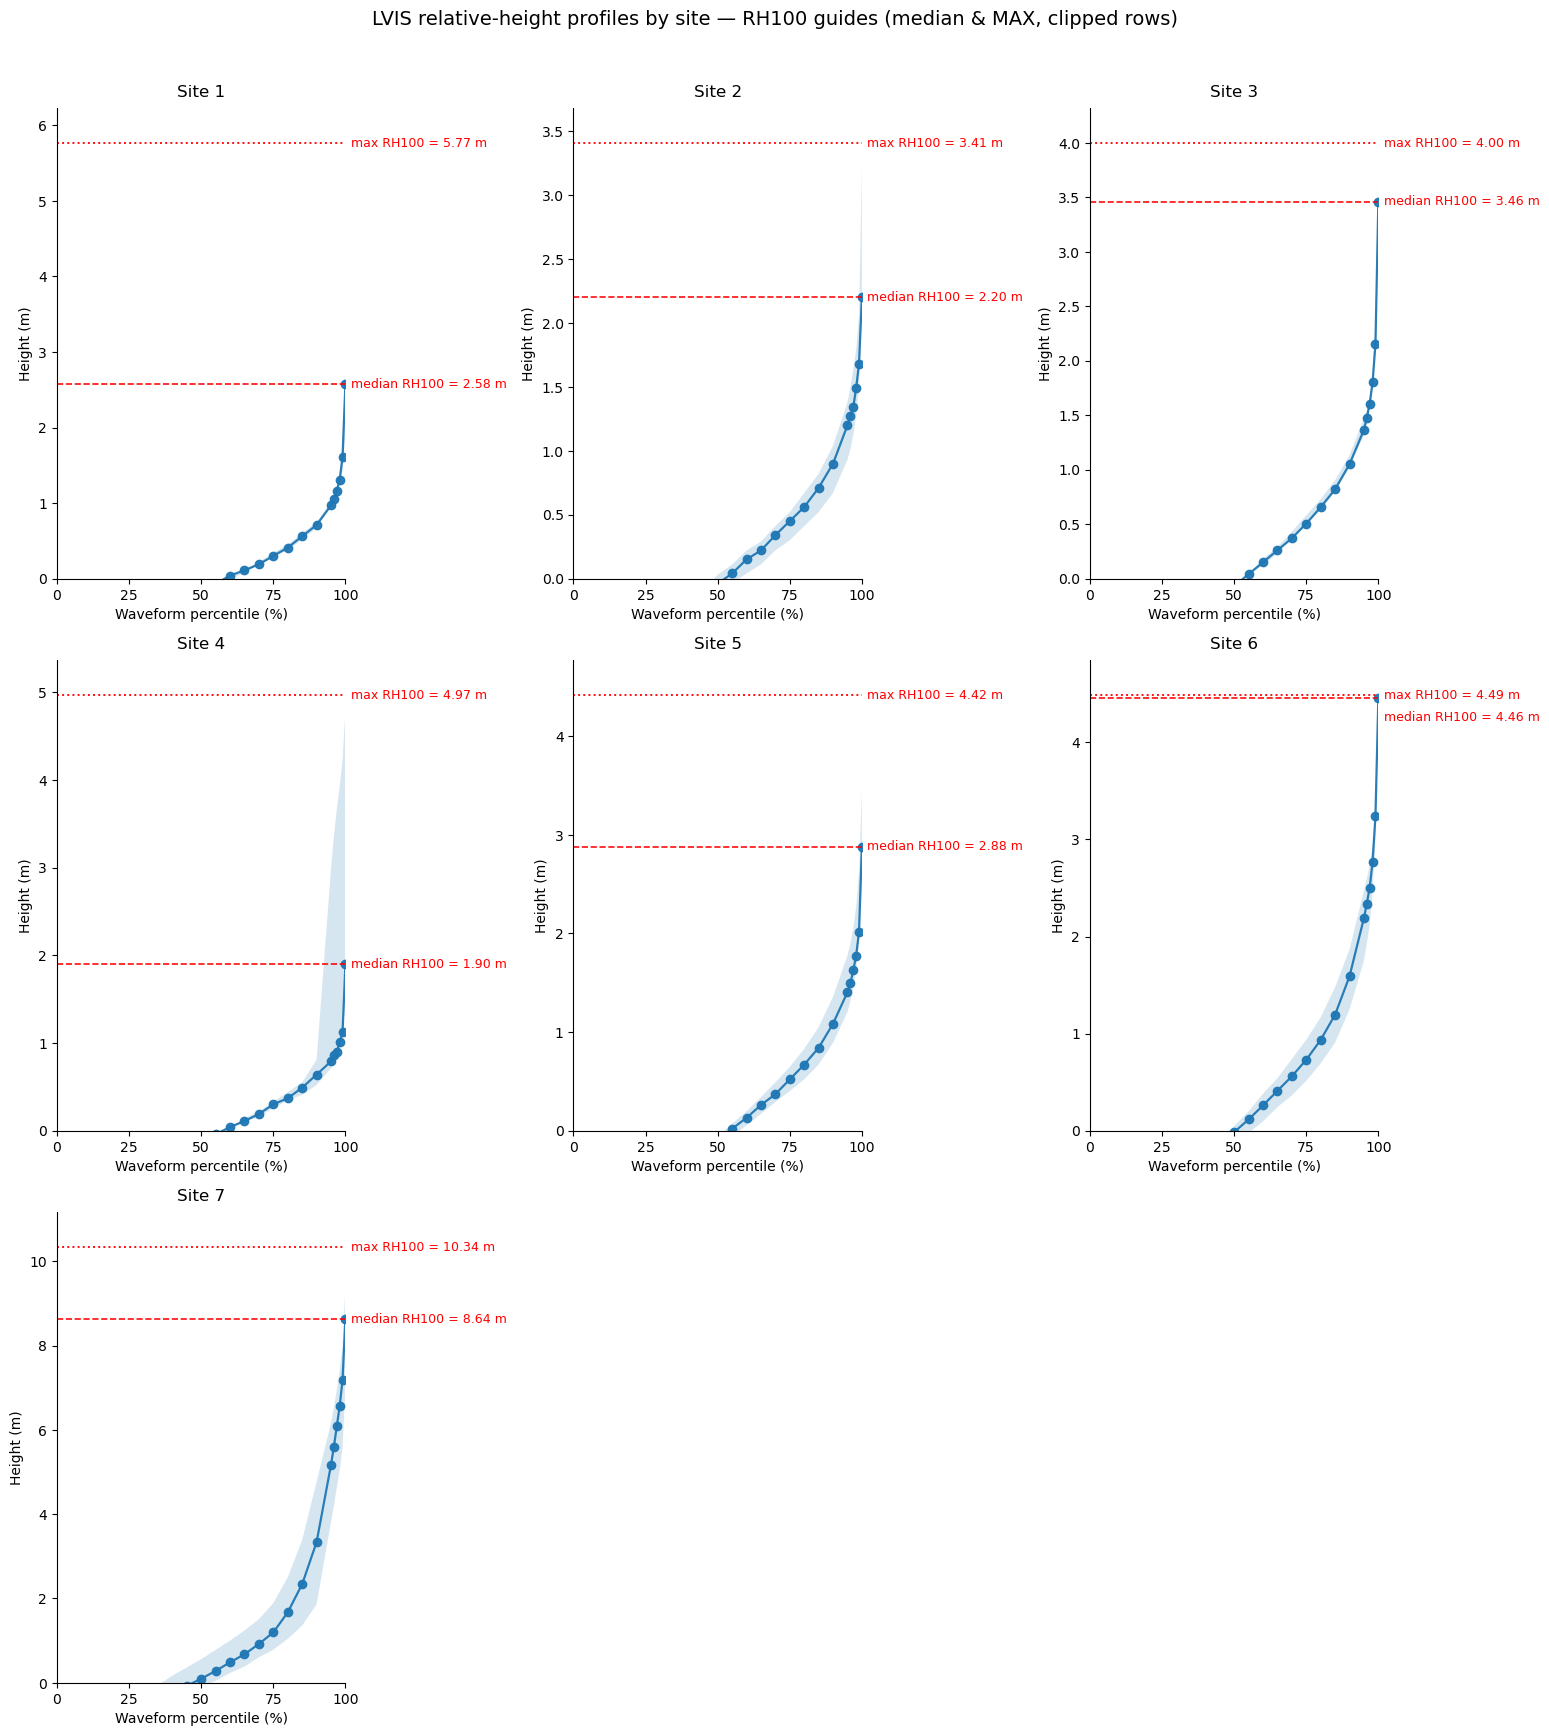

In [17]:
import os, re as _re
import numpy as _np
import pandas as _pd
import geopandas as _gpd
import matplotlib.pyplot as _plt
from math import ceil as _ceil

Out_dir = "data/outputs/figures3"
os.makedirs(out_dir, exist_ok=True)

# Inputs & CRS
Base_gdf  = Lvis_l2a_geodataframe.copy()
Polygons_reference_gdf = Sites_polygons_web_gdf if 'Sites_polygons_web_gdf' in globals() else Buffer_polygons_web_gdf
Base_gdf  = Base_gdf.drop(columns=["index_left","index_right"], errors="ignore").reset_index(drop=True)
Polygons_reference_gdf = Polygons_reference_gdf.drop(columns=["index_left","index_right"], errors="ignore").reset_index(drop=True)

if Base_gdf.crs is None:
    raise ValueError("Lvis_l2a_geodataframe has no CRS.")
if Polygons_reference_gdf.crs != Base_gdf.crs:
    Polygons_reference_gdf = Polygons_reference_gdf.to_crs(Base_gdf.crs)

# Decide which polygon column labels sites; if none, create one
candidate_fields = [c for c in Polygons_reference_gdf.columns if c.lower() in {"site","site_id","plot","plot_id","id","name"}]
Site_field_name = candidate_fields[0] if candidate_fields else "site"
if Site_field_name not in Polygons_reference_gdf.columns:
    Polygons_reference_gdf[Site_field_name] = _np.arange(1, len(Polygons_reference_gdf)+1)

# Keep a copy of polygon labels keyed by their index (for the fallback via index_right)
polygon_labels_by_index = Polygons_reference_gdf.reset_index()[["index", Site_field_name]].set_index("index")[Site_field_name]

# Spatial join (within)
Clipped_gdf = gpd.sjoin(
    Base_gdf,
    Polygons_reference_gdf[[Site_field_name,"geometry"]].rename(columns={Site_field_name:"site"}),
    predicate="within",
    how="inner",
    lsuffix="pt",
    rsuffix="poly"
)

# Canonicalise a 'site' column robustly BEFORE dropping anything
if "site" not in Clipped_gdf.columns:
    if "site_poly" in Clipped_gdf.columns:
        Clipped_gdf["site"] = Clipped_gdf["site_poly"]
    elif "index_right" in Clipped_gdf.columns:
        # Map polygon index to its label
        Clipped_gdf["site"] = Clipped_gdf["index_right"].map(polygon_labels_by_index)
    else:
        # last resort: make a sequential label per polygon index seen
        if "index_right" not in Clipped_gdf.columns:
            Clipped_gdf = Clipped_gdf.reset_index(names="index_right")
        codes = Clipped_gdf["index_right"].astype("category").cat.codes + 1
        Clipped_gdf["site"] = codes

# Now drop sjoin by-products
Clipped_gdf = Clipped_gdf.drop(columns=["site_poly","index_left","index_right"], errors="ignore")

# Clean site labels (avoid "Site Site1")
def Clean_site_label(raw_value):
    s = str(raw_value).strip()
    s = _re.sub(r"^\s*site\s*", "", s, flags=_re.IGNORECASE)
    try:
        return int(float(s))
    except Exception:
        return s

Clipped_gdf["site_clean"] = Clipped_gdf["site"].apply(Clean_site_label)

# RH columns & profile matrix
rh_columns = sorted([c for c in Clipped_gdf.columns if __re.fullmatch(r"RH\d+", c)],
                 key=lambda x: int(x[2:]))
if len(rh_columns) < 3:
    raise RuntimeError(f"Need multiple RH columns; found {rh_columns}. Use the full LVIS table, not an RH100-only export.")

def Profile_matrix(df_site):
    M_matrix = df_site[rh_columns].T.copy()
    M_matrix.index = M_matrix.index.str.replace("RH","", regex=False).astype(int)
    M_matrix.sort_index(inplace=True)
    return M_matrix

# Plot: one panel per site; guides at RH100 (median dashed, MAX dotted)
sites_list = sorted(pd.unique(Clipped_gdf["site_clean"]), key=lambda x: (isinstance(x,str), x))
n_cols, n_rows = 3, _ceil(len(sites_list)/3)
fig, axes = _plt.subplots(n_rows, n_cols, figsize=(n_cols*5.2, n_rows*5.8), squeeze=False)
axes = axes.ravel()

for ax in axes:
    ax.grid(False)
    for s in ("top","right"):
        ax.spines[s].set_visible(False)

for i, s in enumerate(sites_list):
    ax  = axes[i]
    sub = Clipped_gdf.loc[Clipped_gdf["site_clean"] == s]
    if sub.empty:
        ax.set_visible(False); continue
    
    M_matrix   = Profile_matrix(sub)
    q1         = M_matrix.quantile(0.25, axis=1)
    med        = M_matrix.quantile(0.50, axis=1)
    q3         = M_matrix.quantile(0.75, axis=1)

    top_pct = 100 if 100 in M_matrix.index else int(M_matrix.index.max())
    med_top = float(med.loc[top_pct])
    max_top = float(M_matrix.loc[top_pct].max())

    # Curve + ribbon
    ax.plot(M_matrix.index, med, marker="o", lw=1.6, alpha=0.95)
    ax.fill_between(M_matrix.index, q1, q3, alpha=0.18)
    
    # Per-site y-scale and guides
    y_top = max(max_top, med_top, float(q3.max())) * 1.08
    ax.set_ylim(0.0, y_top)
    ax.axhline(med_top, ls="--", lw=1.2, color="red", alpha=0.95)
    ax.axhline(max_top, ls=":",  lw=1.4, color="red", alpha=0.95)

    # Anti-overlap: nudge lower label if lines are very close
    y_rng = y_top if y_top > 0 else 1.0
    med_y, max_y = med_top, max_top
    if abs(max_top - med_top) < 0.06 * y_rng:
        if med_top <= max_top:
            med_y = med_top - 0.04 * y_rng
        else:
            max_y = max_top - 0.04 * y_rng

    ax.text(100.5, med_y, f" median RH{top_pct} = {med_top:.2f} m",
            va="center", ha="left", fontsize=9, color="red")
    ax.text(100.5, max_y, f" max RH{top_pct} = {max_top:.2f} m",
            va="center", ha="left", fontsize=9, color="red")
    
    # Axes cosmetics
    ax.set_title(f"Site {s}", pad=8)
    ax.set_xlabel("Waveform percentile (%)")
    ax.set_ylabel("Height (m)")
    ax.set_xlim(0, 100)
    ax.set_xticks([0, 25, 50, 75, 100])

# Hide unused panels
for j in range(i+1, n_rows*n_cols):
    axes[j].set_visible(False)

fig.suptitle("LVIS relative-height profiles by site — RH100 guides (median & MAX, clipped rows)",
             y=0.995, fontsize=14)
fig.tight_layout(rect=[0, 0, 1, 0.98])

In [18]:
# Save

Out_dir = "data/outputs/figures3"
os.makedirs(Out_dir, exist_ok=True)

fname_base = "lvis_profiles_by_site_rh100_guides_CLIPPED_fixed_xticks_FINAL"
png_path = os.path.abspath(os.path.join(Out_dir, f"{fname_base}.png"))
pdf_path = os.path.abspath(os.path.join(Out_dir, f"{fname_base}.pdf"))

fig.tight_layout(rect=[0, 0, 1, 0.98])
fig.savefig(png_path, dpi=300, bbox_inches="tight")
fig.savefig(pdf_path, dpi=300, bbox_inches="tight")
print("Wrote:", png_path)
print("Wrote:", pdf_path)

_plt.close(fig)

Wrote: /home/prutlokoane/data/outputs/figures3/lvis_profiles_by_site_rh100_guides_CLIPPED_fixed_xticks_FINAL.png
Wrote: /home/prutlokoane/data/outputs/figures3/lvis_profiles_by_site_rh100_guides_CLIPPED_fixed_xticks_FINAL.pdf
